# BigBird Text classification Tutorial *Longformer*

*Big Bird* is part of a new generation of Transformer based architectures that try to solve the main limitation of attention mechanisms; the quadratic nature of attention. These address this problem finding ways to approximate the full attention matrix without incurring on the memory costs of the full attention model. In a previous [post](https://jesusleal.io/2020/10/20/https://jesusleal.io/2020/11/24/Longformer-with-IMDB/) I explored how to use Hugging Face *Transformers* library to fine tune a Longformer model in a simple multiclass classification setting. In this post I explore the Google *Big Bird* architecture available through the Hugging Face *Transformers* library. 

The *Big Bird* architecture, just as the Longformer expands the number of tokens that the model can process from 512 to 4096 tokens thanks to a new attention mechanism known as *Block Sparse Attention*. This flavor of attention uses a combination of global attention (on selected tokends), window attention (just like LongFormer) and random attention. See the ilustration of the original paper.

[image]

The main idea behind using random attention in addition to window attention is to retain as much information as possible from the original full attention, withou incurring in the memory costs. The authors use graph theory to achieve this objective, specifically they correctly point that in attention all tokens attend to each other,usingIf the model wants to get information between tokens it can do it in a single step in the full attention model as the shortest path is simply 1. With BigBird (and Longformer) the shortest path will not not always be 1 and as result we may need multiple layers of attention to effectively access this path. The video by [Yannic Kilcher](https://www.youtube.com/watch?v=WVPE62Gk3EM) explaining the model does a fantastic job at illustrating this point. 


In case, we have many global tokens, then we may not need random connections since there will be multiple short paths through which information can travel. This is the idea behind keeping num_random_tokens = 0 when working with a variant of BigBird, called ETC (more on this in later sections).

In traditional Transformer architectures each token attends to every othertoken and as result the complexity is n2. BigBird uses global attention on selected tokens such as `CLS` so that they can attend to all the tokens in the sequence, window attention where each token attends to $\frac{1}{2}\ w$ tokens to the left and to the right. tokens and random attention where each token follows random tokens. 

As astutely noted by [Vasudev Gupta](https://huggingface.co/blog/big-bird) from Hugging Face the combination of sliding, global and random attention is not easily implemented as it approaches a sparse matrix multiplication. To solve this Big Bird proposes another technical innovation, calculating the attention scores using multiple blocks so the matrix multiplication is not sparse.
[graph of three types of attention]


In the illustration takem from Vasudev's blog we can see that sliding attention shifts the order by a certain amount of tokens and thats how you can implement the window attention. In the example illustrated above the attention block adds 2 'extra' sentences that are shifted to the right and to the left. 






If the model needs to share information between two nodes (or tokens), information will have to travel across various other nodes in the path for some of the tokens; since all the nodes are not directly connected in a single layer.
If the model needs to 

While these long range transformers recognize that they do not strive to be superior to full attention they try to increae the lenght of the sequence they can process, which can be particularly helpful for tasks such as question answering and summarization. In my particular case I am interested in understanding if there is any gain in performance when using these type of attentions when classifiying documents. This is a real use case in industry use; for example see the [adaptations made using BERT](https://arxiv.org/pdf/1904.08398v3.pdf) for long text classification.

The main idea behind this model is to use the notion of random walks in a small world network. 




In [1]:
print(1)

1


In [2]:
import torch
import datasets
import transformers
import pandas as pd
import numpy as np
from torch.nn import BCEWithLogitsLoss
from transformers import BigBirdTokenizer, \
BigBirdForSequenceClassification, Trainer, TrainingArguments,EvalPrediction, AutoTokenizer
from torch.utils.data import Dataset, DataLoader
# import wandb
import random

In [58]:
import ast

# Define the path to your text file
file_path = '/Text_Extraction/Shishir - MISC/top_sentences_new.txt'


# Initialize an empty list to store the tuples
top_sentences_new = []
label_new=[]

# Read and parse the file
with open(file_path, 'r') as file:
    for line in file:
        # Convert string to list of tuples and integer
        evaluated_result = ast.literal_eval(line)
        list_of_tuples = evaluated_result[0]
        integer_value = evaluated_result[1]
  

        if list_of_tuples:  # Check if the line is not empty
            # Convert the string representation of the tuple to an actual tuple
            # Append the tuple to the list
            
            top_sentences_new.append(ast.literal_eval(list_of_tuples))
            label_new.append(integer_value)

In [63]:
txt_arr=[]

for p in top_sentences_new:
    p.sort(key=lambda x:x[2])
    txt_arr.append(". ".join([i[0] for i in p]))
        


In [86]:
from sklearn.model_selection import train_test_split
import numpy as np
import pyarrow as pa
import pyarrow.dataset as ds

# Assuming you have two arrays: txt_arr and label_new
# txt_arr contains the text data and label_new contains corresponding labels

# Split the data into training and testing sets with an 80-20 split
X_train, X_test, y_train, y_test = train_test_split(txt_arr, label_new, test_size=0.1, random_state=42)


import pyarrow as pa
import pyarrow.dataset as ds
import pandas as pd
from datasets import Dataset

df_train = pd.DataFrame({'text': X_train, 'label': y_train})
df_test = pd.DataFrame({'text': X_test, 'label': y_test})

# dataset_train = ds.dataset(pa.Table.from_pandas(df_train).to_batches())
# dataset_test = ds.dataset(pa.Table.from_pandas(df_test).to_batches())


### convert to Huggingface dataset
train_data = Dataset(pa.Table.from_pandas(df_train))
test_data = Dataset(pa.Table.from_pandas(df_test))




In [88]:
train_data,test_data

(Dataset({
     features: ['text', 'label'],
     num_rows: 9000
 }),
 Dataset({
     features: ['text', 'label'],
     num_rows: 1000
 }))

In [90]:
# train_data, test_data = datasets.load_dataset("ccdv/patent-classification", split =['train', 'test'], 
#                                              cache_dir="/Text_Extraction/Shishir - MISC/Data")

In [112]:
# load model and tokenizer and define length of the text sequence



from transformers import BigBirdForSequenceClassification, AutoTokenizer,RobertaForSequenceClassification

model = RobertaForSequenceClassification.from_pretrained("FacebookAI/roberta-base",
    # 'google/bigbird-roberta-base',
                # gradient_checkpointing=False,
                num_labels = 9,
                cache_dir="/Text_Extraction/Shishir - MISC/Facebook_Roberta_models/",
               # "/Text_Extraction/Shishir - MISC/Bigbird_Roberta_models/",
                return_dict=True)

# Load the saved model
# model = BigBirdForSequenceClassification.from_pretrained("/Text_Extraction/Shishir - MISC/Bigbird_Roberta_models/results/bigbird_base_patents")

# Load the saved tokenizer
tokenizer = AutoTokenizer.from_pretrained(
    "FacebookAI/roberta-base"
    # "/Text_Extraction/Shishir - MISC/Bigbird_Roberta_models/results/bigbird_base_patents"
                )



Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at FacebookAI/roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [93]:
# model

In [113]:
# tokenizer = AutoTokenizer.from_pretrained('google/bigbird-roberta-base', 
#                                           max_length = 2048,
#                                           # cache_dir='/media/data_files/github/website_tutorials/data',
#                                          )

One of the cool features about this model is that you can specify the attention sliding window across different levels; the authors exploited this design for the autoregressive language model using different sliding windows for different layers. If this parameter is not changed it will assume a default of 512 across all the different layers.

wandb.login()

In [114]:
train_data
#dir(train_data)

Dataset({
    features: ['text', 'label', 'input_ids', 'attention_mask'],
    num_rows: 9000
})

In [127]:
# define a function that will tokenize the model, and will return the relevant inputs for the model
def tokenization(batched_text):
    return tokenizer(batched_text['text'], padding = 'max_length', truncation=True, max_length = 512)

train_data = train_data.map(tokenization, batched = True, batch_size = len(train_data))
test_data = test_data.map(tokenization, batched = True, batch_size = len(test_data))

Map:   0%|          | 0/9000 [00:00<?, ? examples/s]

Map:   0%|          | 0/1000 [00:00<?, ? examples/s]

In [128]:
# we make sure our truncation strateging and the padding are set to the maximung length
len(train_data['input_ids'][0])

512

In [129]:
from sklearn.utils.class_weight import compute_class_weight

# Extract labels from the dataset
train_labels = train_data['label']
train_labels=[int(i) for i in train_labels]

# Get unique labels present in train_labels
unique_labels = np.unique(train_labels)

# Compute the class weights
class_wts = compute_class_weight(class_weight='balanced', classes=unique_labels, y=train_labels)
class_wts

array([ 0.74294205,  0.83963056,  1.24843945, 14.92537313,  4.06504065,
        1.64744646,  0.51759834,  0.52966102,  1.0845987 ])

In [130]:
import torch.nn as nn

class_weights_tensor = torch.tensor(class_wts, dtype=torch.float32)
loss_function = nn.CrossEntropyLoss(weight=class_weights_tensor)

Once the tokenization process is finished we can use the set the column names and types. One thing that is important to note is that the `LongformerForSequenceClassification` implementation by default sets the global attention to the `CLS`[token](https://huggingface.co/transformers/_modules/transformers/modeling_longformer.html#LongformerForSequenceClassification), so there is no need to further modify the inputs.

In [131]:
train_data.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])
test_data.set_format('torch', columns=['input_ids', 'attention_mask', 'label'])

In [132]:
# define accuracy metrics
from sklearn.metrics import precision_recall_fscore_support, accuracy_score
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    # argmax(pred.predictions, axis=1)
    #pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='weighted')
    
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

In [133]:
# !pip install accelerate -U
# # !pip install accelerate -U
# from sklearn.utils.class_weight import compute_class_weight


# # Compute the class weights
# class_wts = compute_class_weight(class_weight='balanced', classes=np.unique(train_labels_new), y=train_labels_new)

TRAINING TIME

In [134]:
# define the training arguments
training_args = TrainingArguments(
    output_dir = "/Text_Extraction/Shishir - MISC/Facebook-Roberta/output",
    num_train_epochs = 4,
    per_device_train_batch_size = 8,
    gradient_accumulation_steps = 4,    
    per_device_eval_batch_size= 8,
    evaluation_strategy = "epoch",
    save_strategy="epoch",
    disable_tqdm = False, 
    load_best_model_at_end=True,
    warmup_steps=160,
    weight_decay=0.01,
    logging_steps = 4,
    learning_rate = 1e-5,
    fp16 = True,
    logging_dir="/Text_Extraction/Shishir - MISC/Facebook-Roberta/logs",
    dataloader_num_workers = 0,
    run_name = 'bigbird_classification_3000'
)

In [135]:
# instantiate the trainer class and check for available devices
trainer = Trainer(
    model=model,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=train_data,
    eval_dataset=test_data,
     # train_loss=loss_function
)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


'cuda'

In [136]:
# train the model
trainer.train()

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
0,1.435900,1.393218,0.517000,0.477318,0.461643,0.517000
1,1.187900,1.215071,0.587000,0.551419,0.568405,0.587000
2,1.075500,1.152278,0.595000,0.563402,0.573722,0.595000
3,0.960300,1.127977,0.604000,0.572019,0.575501,0.604000


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was

TrainOutput(global_step=560, training_loss=1.292307447535651, metrics={'train_runtime': 505.4152, 'train_samples_per_second': 71.229, 'train_steps_per_second': 1.108, 'total_flos': 9424177832779776.0, 'train_loss': 1.292307447535651, 'epoch': 3.9786856127886323})

In [137]:
trainer.train()

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
0,1.012000,1.128742,0.606000,0.569433,0.568041,0.606000
1,0.920300,1.113840,0.611000,0.585315,0.588041,0.611000
2,0.863700,1.140912,0.612000,0.587294,0.584691,0.612000
3,0.721700,1.108599,0.636000,0.610440,0.611104,0.636000


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


TrainOutput(global_step=560, training_loss=0.8611759573221207, metrics={'train_runtime': 512.4378, 'train_samples_per_second': 70.252, 'train_steps_per_second': 1.093, 'total_flos': 9424177832779776.0, 'train_loss': 0.8611759573221207, 'epoch': 3.9786856127886323})

In [106]:
# # Get the model's named parameters
# named_parameters = list(model.named_parameters())

# # Extract the names of trainable parameters
# trainable_parameters = [name for name, param in named_parameters if param.requires_grad]

# # Print or inspect the trainable parameters
# print("Trainable Parameters:")
# print(trainable_parameters)

# Verify which parameters are frozen and which are not
for name, param in model.named_parameters():
    print(f"{name}: requires_grad={param.requires_grad}")


bert.embeddings.word_embeddings.weight: requires_grad=True
bert.embeddings.position_embeddings.weight: requires_grad=True
bert.embeddings.token_type_embeddings.weight: requires_grad=True
bert.embeddings.LayerNorm.weight: requires_grad=True
bert.embeddings.LayerNorm.bias: requires_grad=True
bert.encoder.layer.0.attention.self.query.weight: requires_grad=True
bert.encoder.layer.0.attention.self.query.bias: requires_grad=True
bert.encoder.layer.0.attention.self.key.weight: requires_grad=True
bert.encoder.layer.0.attention.self.key.bias: requires_grad=True
bert.encoder.layer.0.attention.self.value.weight: requires_grad=True
bert.encoder.layer.0.attention.self.value.bias: requires_grad=True
bert.encoder.layer.0.attention.output.dense.weight: requires_grad=True
bert.encoder.layer.0.attention.output.dense.bias: requires_grad=True
bert.encoder.layer.0.attention.output.LayerNorm.weight: requires_grad=True
bert.encoder.layer.0.attention.output.LayerNorm.bias: requires_grad=True
bert.encoder.laye

After the training has been completed we can evaluate the performance of the model and make sure we are loading the right model.

In [107]:
# save the best model
trainer.model.save_pretrained("/Text_Extraction/Shishir - MISC/Bigbird_Roberta_models/results/bigbird_base_patents_ext")
tokenizer.save_pretrained("/Text_Extraction/Shishir - MISC/Bigbird_Roberta_models/results/bigbird_base_patents_ext")

('/Text_Extraction/Shishir - MISC/Bigbird_Roberta_models/results/bigbird_base_patents/tokenizer_config.json',
 '/Text_Extraction/Shishir - MISC/Bigbird_Roberta_models/results/bigbird_base_patents/special_tokens_map.json',
 '/Text_Extraction/Shishir - MISC/Bigbird_Roberta_models/results/bigbird_base_patents/spiece.model',
 '/Text_Extraction/Shishir - MISC/Bigbird_Roberta_models/results/bigbird_base_patents/added_tokens.json',
 '/Text_Extraction/Shishir - MISC/Bigbird_Roberta_models/results/bigbird_base_patents/tokenizer.json')

In [22]:
trainer.evaluate()

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


{'eval_loss': 1.0142598152160645,
 'eval_accuracy': 0.666,
 'eval_f1': 0.6430270016135043,
 'eval_precision': 0.6393865964314894,
 'eval_recall': 0.666,
 'eval_runtime': 115.6155,
 'eval_samples_per_second': 43.247,
 'eval_steps_per_second': 2.707,
 'epoch': 3.9923224568138194}

In [109]:
trainer.evaluate()

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


{'eval_loss': 1.1050578355789185,
 'eval_accuracy': 0.617,
 'eval_f1': 0.5847711026054063,
 'eval_precision': 0.57647274891088,
 'eval_recall': 0.617,
 'eval_runtime': 22.9517,
 'eval_samples_per_second': 43.57,
 'eval_steps_per_second': 2.745,
 'epoch': 3.9786856127886323}

In [25]:
subjects={
          0:"Human Necessities",
          1:"Performing Operations; Transporting",
          2:"Chemistry; Metallurgy",
          3:"Textiles; Paper",
          4:"Fixed Constructions",
          5:"Mechanical Engineering; Lightning; Heating; Weapons; Blasting",
          6:"Physics",
          7:"Electricity",
          8:"General tagging of new or cross-sectional technology"
         }

In [23]:
# Make predictions on the test dataset
predictions = trainer.predict(test_data)

# Extract predicted labels and true labels
predicted_labels = predictions.predictions.argmax(axis=1)
true_labels = predictions.label_ids

# Calculate confusion matrix
from sklearn.metrics import confusion_matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)
conf_matrix_percent = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

# Print or visualize the confusion matrix
print("Confusion Matrix:")
print(conf_matrix)

/opt/conda/lib/python3.10/site-packages/torch/nn/parallel/_functions.py:68: UserWarning: Was asked to gather along dimension 0, but all input tensors were scalars; will instead unsqueeze and return a vector.
  warnings.warn('Was asked to gather along dimension 0, but all '


Confusion Matrix:
[[574  45  70   1   2   6  36   6  14]
 [ 37 416  65   1  14  27  43  26  20]
 [ 10  11 344   3   1   3   7  10   5]
 [  1   5   7  27   0   0   2   2   0]
 [  5  24   5   0  98   6   4   2  12]
 [ 13  50   7   1  12 214  17  24  20]
 [ 38  39  25   0   3  10 802 183   7]
 [ 13  10  20   0   1  11 142 825  13]
 [ 66  97  86   0  11  57  64  92  30]]


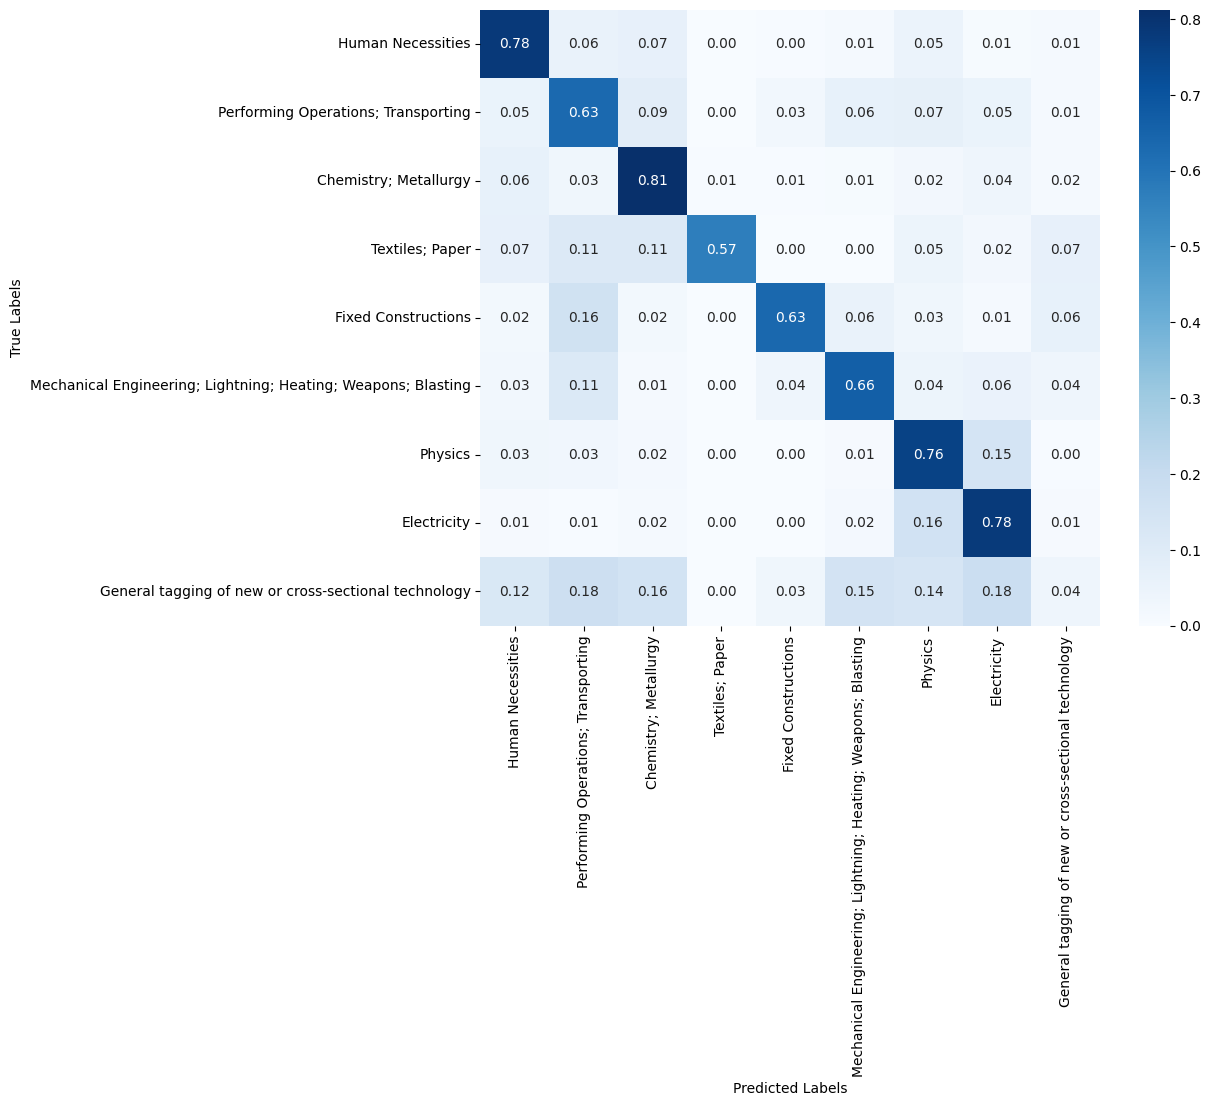

In [46]:
# Define the class labels
import matplotlib.pyplot as plt
import seaborn as sns 
class_labels = [subjects[i] for i in range(len(subjects))]

# # Plot the confusion matrix
# plt.figure(figsize=(10, 8))
# sns.heatmap(conf_matrix_percent, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
# plt.xlabel('Predicted Labels')
# plt.ylabel('True Labels')
# plt.title('Confusion Matrix')
# plt.show()


plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_percent, annot=True, fmt='.2f', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

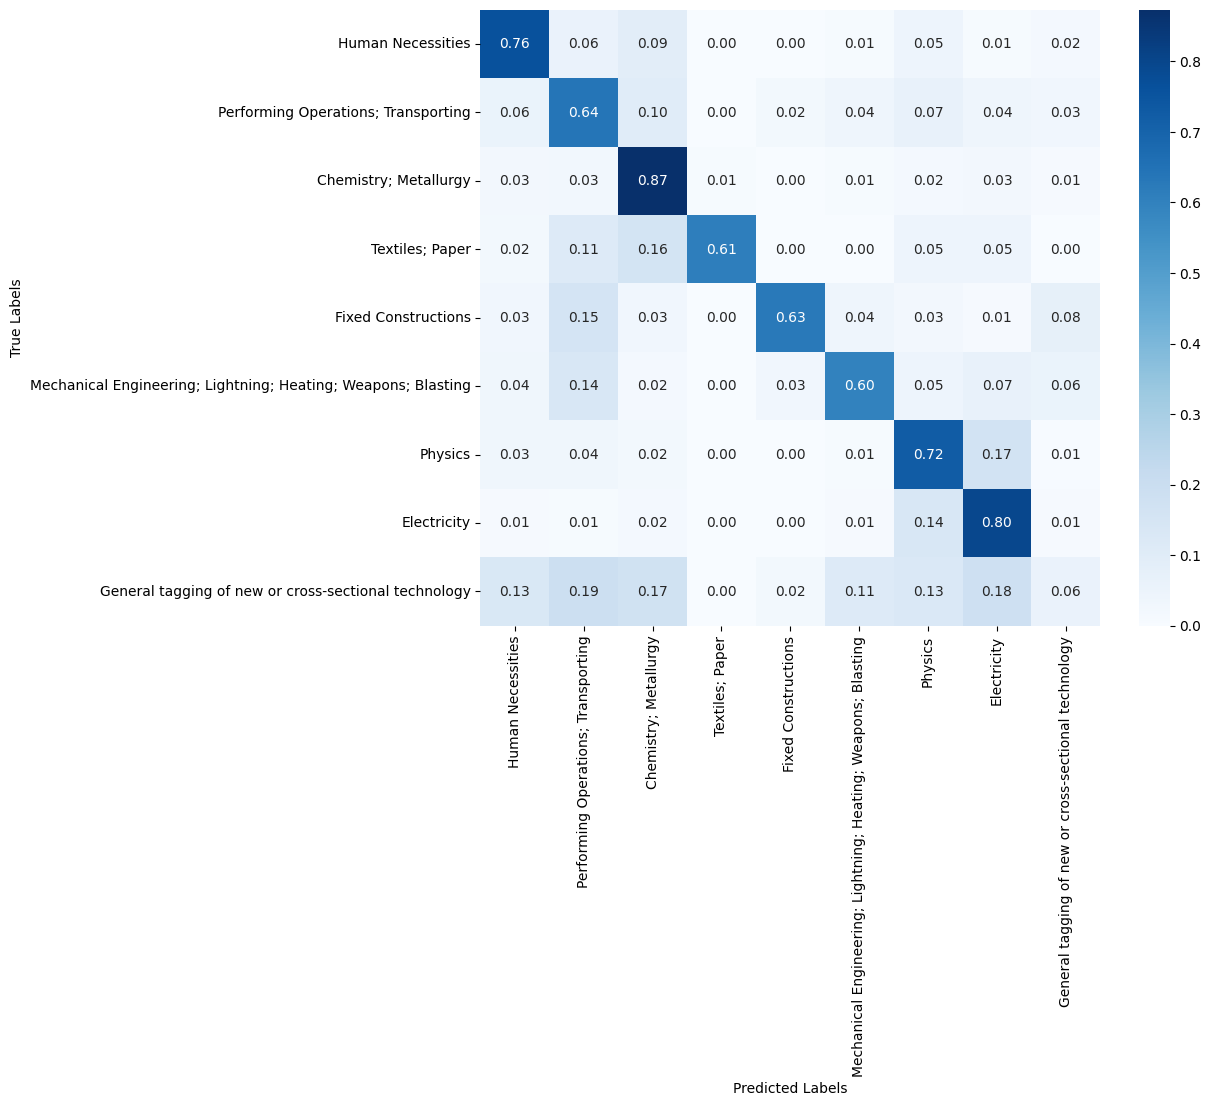

In [26]:
# Define the class labels
import matplotlib.pyplot as plt
import seaborn as sns 
class_labels = [subjects[i] for i in range(len(subjects))]

# # Plot the confusion matrix
# plt.figure(figsize=(10, 8))
# sns.heatmap(conf_matrix_percent, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
# plt.xlabel('Predicted Labels')
# plt.ylabel('True Labels')
# plt.title('Confusion Matrix')
# plt.show()


plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_percent, annot=True, fmt='.2f', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [141]:
import requests
import base64
from PIL import Image
from io import BytesIO
import os


def encode_image_to_base64(image_path):
    with open(image_path, "rb") as image_file:
        encoded_string = base64.b64encode(image_file.read()).decode('utf-8')
    return encoded_string

def send_image_to_api(api_url, image_path):
    # Encode the image to base64
    encoded_image = encode_image_to_base64(image_path)
    
    # Create the payload
    payload = {
        "imgdata": encoded_image,
        "user_id":"demo"
    }
    
    # Send the POST request
    response = requests.post(api_url, json=payload)
    
    # Check the response
    if response.status_code == 200:
        print("Image uploaded successfully")
        print(response.json())  # Assuming the API returns a JSON response
    else:
        print(f"Failed to upload image. Status code: {response.status_code}")
        print(response.text)

# URL of the API endpoint
api_url = "http://20.235.10.4:8003/uploadimage"

# Path to the image you want to upload
image_path = "flood_image_1.png"

# Call the function to send the image to the API
send_image_to_api(api_url, image_path)


Image uploaded successfully
1



Conclustion

![Results](images/longformer_eval_accuracy_imdb.svg)

Thats it for this tutorial, hopefully you will find this helpful.